In [1]:
import pandas as pd
import requests
from xgboost import XGBRegressor
import os
from dotenv import load_dotenv
load_dotenv()
from supabase import create_client, Client
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
url = os.environ.get("SUPABASE_URL")
key = os.environ.get("SUPABASE_KEY")

supabase = create_client(url, key)

In [3]:
bien = supabase.table("bien").select("*").execute()
vente = supabase.table("vente").select("*").execute()
commune = supabase.table("commune").select("*").execute()
region = supabase.table("region").select("*").execute()

2024-04-08 10:02:35,124:INFO - HTTP Request: GET https://qsfxncgsycgttcgjhckl.supabase.co/rest/v1/bien?select=%2A "HTTP/1.1 200 OK"
2024-04-08 10:02:37,598:INFO - HTTP Request: GET https://qsfxncgsycgttcgjhckl.supabase.co/rest/v1/vente?select=%2A "HTTP/1.1 200 OK"
2024-04-08 10:02:38,520:INFO - HTTP Request: GET https://qsfxncgsycgttcgjhckl.supabase.co/rest/v1/commune?select=%2A "HTTP/1.1 200 OK"
2024-04-08 10:02:38,648:INFO - HTTP Request: GET https://qsfxncgsycgttcgjhckl.supabase.co/rest/v1/region?select=%2A "HTTP/1.1 200 OK"


In [4]:
bien_df = pd.DataFrame(bien)
bien_df = bien_df[1].iloc[0]
bien_df = pd.DataFrame(bien_df)
bien_df.head()

,index,No voie,Type de voie,Voie,Code postal,Commune,Code departement,Code commune,Surface Carrez du 1er lot,Type local,Nombre pieces principales,id_bien,id_codedep_codecommune
0,0,6.0,AV,DU CHAMP DE FOIRE,1000,BOURG-EN-BRESSE,01,53,31.68,Appartement,1,1,01_53
1,1,16.0,RUE,DES GRAVES,1000,BOURG-EN-BRESSE,01,53,78.03,Appartement,3,2,01_53
2,2,12.0,ALL,DE LA PETITE REYSSOUZE,1000,BOURG-EN-BRESSE,01,53,74.07,Appartement,3,3,01_53
3,3,18.0,RUE,DES GRAVES,1000,BOURG-EN-BRESSE,01,53,91.47,Appartement,4,4,01_53
4,4,5.0,RUE,EDGAR QUINET,1000,BOURG-EN-BRESSE,01,53,48.48,Appartement,2,5,01_53


In [5]:
commune_df = pd.DataFrame(commune)
commune_df = commune_df[1].iloc[0]
commune_df = pd.DataFrame(commune_df)
commune_df.head()

,Code postal,Commune,Code commune,Code departement,id_codedep_codecommune,region_code
0,1000,BOURG-EN-BRESSE,53,01,01_53,84
1,1960,PERONNAS,289,01,None,84
2,1270,VILLEMOTIER,445,01,01_53,84
3,1290,PONT-DE-VEYLE,306,01,01_445,84
4,1370,SAINT-ETIENNE-DU-BOIS,350,01,01_53,84


In [6]:
vente_df = pd.DataFrame(vente)
vente_df = vente_df[1].iloc[0]
vente_df = pd.DataFrame(vente_df)
vente_df.head()

,id_vente,id_bien,Date mutation,Valeur fonciere
0,1,1,2020-01-06,54800.0
1,2,2,2020-01-13,97000.0
2,3,3,2020-01-07,96000.0
3,4,4,2020-01-09,99000.0
4,5,5,2020-01-08,70000.0


In [7]:
region_df = pd.DataFrame(region)
region_df = region_df[1].iloc[0]
region_df = pd.DataFrame(region_df)
region_df.head()

,code_region,nom_region
0,1,Guadeloupe
1,2,Martinique
2,3,Guyane
3,4,La Réunion
4,6,Mayotte


In [8]:
clean_df = bien_df.merge(vente_df, left_on='id_bien', right_on="id_bien", how='outer')
clean_df = clean_df.merge(commune_df, left_on='id_codedep_codecommune', right_on='id_codedep_codecommune', how='outer')
clean_df = clean_df.merge(region_df, left_on='region_code', right_on='code_region', how='outer')
clean_df

,index,No voie,Type de voie,Voie,Code postal_x,Commune_x,Code departement_x,Code commune_x,Surface Carrez du 1er lot,Type local,...,id_vente,Date mutation,Valeur fonciere,Code postal_y,Commune_y,Code commune_y,Code departement_y,region_code,code_region,nom_region
0,0,6.0,AV,DU CHAMP DE FOIRE,1000.0,BOURG-EN-BRESSE,01,53.0,31.68,Appartement,...,1.0,2020-01-06,54800.0,1000.0,BOURG-EN-BRESSE,53.0,01,84.0,84.0,Auvergne-Rhône-Alpes
1,0,6.0,AV,DU CHAMP DE FOIRE,1000.0,BOURG-EN-BRESSE,01,53.0,31.68,Appartement,...,1.0,2020-01-06,54800.0,1270.0,VILLEMOTIER,445.0,01,84.0,84.0,Auvergne-Rhône-Alpes
2,0,6.0,AV,DU CHAMP DE FOIRE,1000.0,BOURG-EN-BRESSE,01,53.0,31.68,Appartement,...,1.0,2020-01-06,54800.0,1370.0,SAINT-ETIENNE-DU-BOIS,350.0,01,84.0,84.0,Auvergne-Rhône-Alpes
3,0,6.0,AV,DU CHAMP DE FOIRE,1000.0,BOURG-EN-BRESSE,01,53.0,31.68,Appartement,...,1.0,2020-01-06,54800.0,1340.0,MONTREVEL-EN-BRESSE,266.0,01,84.0,84.0,Auvergne-Rhône-Alpes
4,0,6.0,AV,DU CHAMP DE FOIRE,1000.0,BOURG-EN-BRESSE,01,53.0,31.68,Appartement,...,1.0,2020-01-06,54800.0,1750.0,SAINT-LAURENT-SUR-SAONE,370.0,01,84.0,84.0,Auvergne-Rhône-Alpes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4702383,205693,51.0,RUE,AU MAIRE,75003.0,PARIS 03,75,103.0,21.34,Appartement,...,205694.0,2020-11-25,251000.0,97421.0,SAINT-LOUIS,14.0,974,4.0,4.0,La Réunion
4702384,205697,47.0,RUE,DE BRETAGNE,75003.0,PARIS 03,75,103.0,142.06,Appartement,...,205698.0,2020-11-04,2370000.0,97421.0,SAINT-LOUIS,14.0,974,4.0,4.0,La Réunion
4702385,205702,3.0,RUE,DE DURAS,75008.0,PARIS 08,75,108.0,99.08,Appartement,...,205703.0,2020-11-26,1850000.0,97421.0,SAINT-LOUIS,14.0,974,4.0,4.0,La Réunion
4702386,205709,158.0,RUE,DU TEMPLE,75003.0,PARIS 03,75,103.0,114.92,Appartement,...,205710.0,2020-11-30,1806650.0,97421.0,SAINT-LOUIS,14.0,974,4.0,4.0,La Réunion


In [9]:
clean_df = clean_df.drop_duplicates(subset="id_vente")
clean_df = clean_df.drop(columns=["Code postal_y","Commune_y","Code commune_y","Code departement_y"])
#clean_df = clean_df.replace("Code postal_x":"Code postal","Commune_x":"Commune","Code departement_x":"Code departement","Code commune_x":"Code commune")
clean_df


,index,No voie,Type de voie,Voie,Code postal_x,Commune_x,Code departement_x,Code commune_x,Surface Carrez du 1er lot,Type local,Nombre pieces principales,id_bien,id_codedep_codecommune,id_vente,Date mutation,Valeur fonciere,region_code,code_region,nom_region
0,0,6.0,AV,DU CHAMP DE FOIRE,1000.0,BOURG-EN-BRESSE,01,53.0,31.68,Appartement,1.0,1.0,01_53,1.0,2020-01-06,54800.0,84.0,84.0,Auvergne-Rhône-Alpes
26,1,16.0,RUE,DES GRAVES,1000.0,BOURG-EN-BRESSE,01,53.0,78.03,Appartement,3.0,2.0,01_53,2.0,2020-01-13,97000.0,84.0,84.0,Auvergne-Rhône-Alpes
52,2,12.0,ALL,DE LA PETITE REYSSOUZE,1000.0,BOURG-EN-BRESSE,01,53.0,74.07,Appartement,3.0,3.0,01_53,3.0,2020-01-07,96000.0,84.0,84.0,Auvergne-Rhône-Alpes
78,3,18.0,RUE,DES GRAVES,1000.0,BOURG-EN-BRESSE,01,53.0,91.47,Appartement,4.0,4.0,01_53,4.0,2020-01-09,99000.0,84.0,84.0,Auvergne-Rhône-Alpes
104,4,5.0,RUE,EDGAR QUINET,1000.0,BOURG-EN-BRESSE,01,53.0,48.48,Appartement,2.0,5.0,01_53,5.0,2020-01-08,70000.0,84.0,84.0,Auvergne-Rhône-Alpes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4702171,205683,17.0,RUE,DE POITOU,75003.0,PARIS 03,75,103.0,60.98,Appartement,3.0,194353.0,94_19,205684.0,2020-11-20,780000.0,4.0,4.0,La Réunion
4702172,205690,21.0,RUE,DU GENERAL FOY,75008.0,PARIS 08,75,108.0,37.07,Appartement,1.0,194360.0,94_19,205691.0,2020-11-10,330000.0,4.0,4.0,La Réunion
4702173,205694,22.0,RUE,MURILLO,75008.0,PARIS 08,75,108.0,63.60,Appartement,2.0,194364.0,94_19,205695.0,2020-11-19,899000.0,4.0,4.0,La Réunion
4702174,205696,88.0,RUE,QUINCAMPOIX,75003.0,PARIS 03,75,103.0,32.62,Appartement,1.0,194366.0,94_19,205697.0,2020-11-13,400000.0,4.0,4.0,La Réunion


In [10]:
clean_df.dropna(inplace=True)
clean_df.isna().sum()

index                        0
No voie                      0
Type de voie                 0
Voie                         0
Code postal_x                0
Commune_x                    0
Code departement_x           0
Code commune_x               0
Surface Carrez du 1er lot    0
Type local                   0
Nombre pieces principales    0
id_bien                      0
id_codedep_codecommune       0
id_vente                     0
Date mutation                0
Valeur fonciere              0
region_code                  0
code_region                  0
nom_region                   0
dtype: int64

In [11]:
clean_df

,index,No voie,Type de voie,Voie,Code postal_x,Commune_x,Code departement_x,Code commune_x,Surface Carrez du 1er lot,Type local,Nombre pieces principales,id_bien,id_codedep_codecommune,id_vente,Date mutation,Valeur fonciere,region_code,code_region,nom_region
0,0,6.0,AV,DU CHAMP DE FOIRE,1000.0,BOURG-EN-BRESSE,01,53.0,31.68,Appartement,1.0,1.0,01_53,1.0,2020-01-06,54800.0,84.0,84.0,Auvergne-Rhône-Alpes
26,1,16.0,RUE,DES GRAVES,1000.0,BOURG-EN-BRESSE,01,53.0,78.03,Appartement,3.0,2.0,01_53,2.0,2020-01-13,97000.0,84.0,84.0,Auvergne-Rhône-Alpes
52,2,12.0,ALL,DE LA PETITE REYSSOUZE,1000.0,BOURG-EN-BRESSE,01,53.0,74.07,Appartement,3.0,3.0,01_53,3.0,2020-01-07,96000.0,84.0,84.0,Auvergne-Rhône-Alpes
78,3,18.0,RUE,DES GRAVES,1000.0,BOURG-EN-BRESSE,01,53.0,91.47,Appartement,4.0,4.0,01_53,4.0,2020-01-09,99000.0,84.0,84.0,Auvergne-Rhône-Alpes
104,4,5.0,RUE,EDGAR QUINET,1000.0,BOURG-EN-BRESSE,01,53.0,48.48,Appartement,2.0,5.0,01_53,5.0,2020-01-08,70000.0,84.0,84.0,Auvergne-Rhône-Alpes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4702170,205678,79.0,RUE,DE TURBIGO,75003.0,PARIS 03,75,103.0,86.37,Appartement,4.0,194348.0,94_19,205679.0,2020-11-17,1248000.0,4.0,4.0,La Réunion
4702171,205683,17.0,RUE,DE POITOU,75003.0,PARIS 03,75,103.0,60.98,Appartement,3.0,194353.0,94_19,205684.0,2020-11-20,780000.0,4.0,4.0,La Réunion
4702172,205690,21.0,RUE,DU GENERAL FOY,75008.0,PARIS 08,75,108.0,37.07,Appartement,1.0,194360.0,94_19,205691.0,2020-11-10,330000.0,4.0,4.0,La Réunion
4702173,205694,22.0,RUE,MURILLO,75008.0,PARIS 08,75,108.0,63.60,Appartement,2.0,194364.0,94_19,205695.0,2020-11-19,899000.0,4.0,4.0,La Réunion


In [12]:
clean_df.dtypes

index                         object
No voie                       object
Type de voie                  object
Voie                          object
Code postal_x                float64
Commune_x                     object
Code departement_x            object
Code commune_x               float64
Surface Carrez du 1er lot    float64
Type local                    object
Nombre pieces principales    float64
id_bien                      float64
id_codedep_codecommune        object
id_vente                     float64
Date mutation                 object
Valeur fonciere              float64
region_code                  float64
code_region                  float64
nom_region                    object
dtype: object

## Entrainement

### MLFlow

In [238]:
import mlflow
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("Immo monitoring")

<Experiment: artifact_location='mlflow-artifacts:/661998002745822665', creation_time=1710494985679, experiment_id='661998002745822665', last_update_time=1710494985679, lifecycle_stage='active', name='Immo monitoring', tags={}>

### Linear reg

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

In [193]:
X = clean_df.drop(columns=["Code commune_x","index","id_codedep_codecommune","nom_region","Valeur fonciere","Date mutation","Type de voie","Voie","Commune_x","Type local","No voie","Code departement_x","id_bien","id_vente", "region_code"])
y = clean_df["Valeur fonciere"]

In [194]:
X.dtypes

Code postal_x                float64
Surface Carrez du 1er lot    float64
Nombre pieces principales    float64
code_region                  float64
dtype: object

In [195]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

In [196]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [197]:
X.isna().sum()

Code postal_x                0
Surface Carrez du 1er lot    0
Nombre pieces principales    0
code_region                  0
dtype: int64

In [239]:
baseline = LinearRegression()
model = baseline.fit(X_train,y_train)

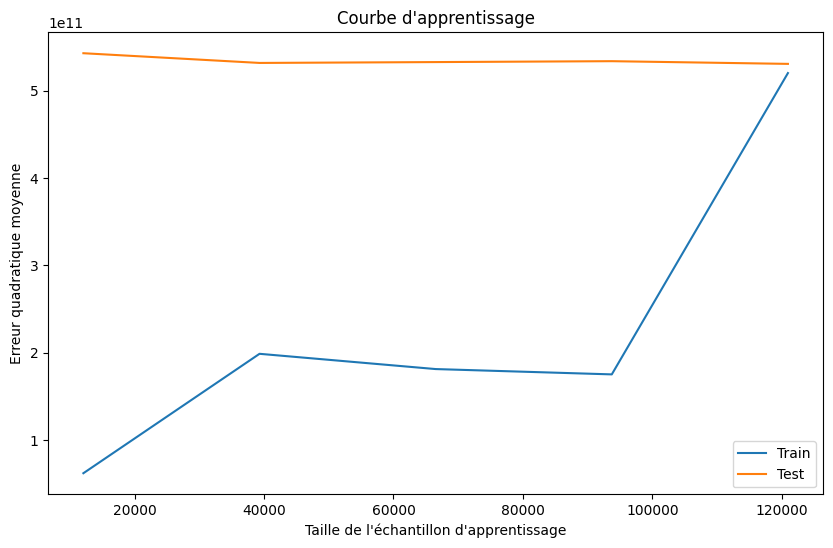

In [240]:
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Taille de l\'échantillon d\'apprentissage')
plt.ylabel('Erreur quadratique moyenne')
plt.title('Courbe d\'apprentissage')
plt.legend()
plt.show()

In [241]:
from sklearn.metrics import mean_squared_error

# Prédiction sur l'ensemble de test
predictions = model.predict(X_test)

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)

# Affichage du score
print(f"Erreur quadratique moyenne (MSE) : {mse}")

Erreur quadratique moyenne (MSE) : 675175326428.6842


In [242]:
from sklearn.metrics import r2_score

# Calcul du coefficient de détermination
r2 = r2_score(y_test, predictions)

# Affichage du score R²
print(f"Coefficient de détermination (R²) : {r2}")

Coefficient de détermination (R²) : 0.015030911032659189


In [243]:
RMSE = np.sqrt(mse)
RMSE

821690.5295965654

In [244]:
from sklearn.metrics import mean_absolute_error

MAE = mean_absolute_error(y_test, predictions)
MAE

149014.88579953613

In [245]:
with mlflow.start_run(run_name="Regression lineaire"):
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("RMSE", RMSE)
    mlflow.log_metric("MAE", MAE)

### Linear reg scale

In [205]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = baseline.fit(X_train_scaled, y_train)

In [206]:
model1 = LinearRegression(fit_intercept=False)
model1 = model1.fit(X_train_scaled, y_train)

In [207]:
# Prédiction sur l'ensemble de test
predictions = model1.predict(X_test)

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)

# Affichage du score
print(f"Erreur quadratique moyenne (MSE) : {mse}")

Erreur quadratique moyenne (MSE) : 3.577624571625413e+18


/home/axxe/.pyenv/versions/simplon/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [208]:
# Calcul du coefficient de détermination
r2 = r2_score(y_test, predictions)

# Affichage du score R²
print(f"Coefficient de détermination (R²) : {r2}")

Coefficient de détermination (R²) : -4121134.514803409


### Ridge reg

In [246]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)  # Vous pouvez ajuster le paramètre alpha
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [247]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=4)  # Choisissez le nombre optimal de caractéristiques (k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [248]:
# Prédiction sur l'ensemble de test
# Prédiction sur l'ensemble de test
predictions = ridge_model.predict(X_test_scaled)

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)

# Affichage du score
print(f"Erreur quadratique moyenne (MSE) : {mse}")

Erreur quadratique moyenne (MSE) : 685529473424.276


In [249]:
# Calcul du coefficient de détermination
r2 = r2_score(y_test, predictions)

# Affichage du score R²
print(f"Coefficient de détermination (R²) : {r2}")

Coefficient de détermination (R²) : -7.407627075228795e-05


In [253]:
with mlflow.start_run(run_name="Ridge Regressor ( standardisé )"):
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("RMSE", RMSE)

### XGB Reg

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

In [252]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=18)

In [54]:
X.shape

(151187, 5)

In [254]:
xgb = XGBRegressor()

In [255]:
model = xgb.fit(X_train, y_train)

In [256]:
# Prédiction sur l'ensemble de test
predictions = model.predict(X_test)

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)

# Affichage du score
print(f"Erreur quadratique moyenne (MSE) : {mse}")

Erreur quadratique moyenne (MSE) : 131202294332.2865


In [257]:
# Calcul du coefficient de détermination
r2 = r2_score(y_test, predictions)

# Affichage du score R²
print(f"Coefficient de détermination (R²) : {r2}")

Coefficient de détermination (R²) : 0.8085975608699214


In [258]:
RMSE = np.sqrt(mse)
RMSE

362218.57259434735

In [259]:
from sklearn.metrics import mean_absolute_error

MAE = mean_absolute_error(y_test, predictions)
MAE

82834.97838144083

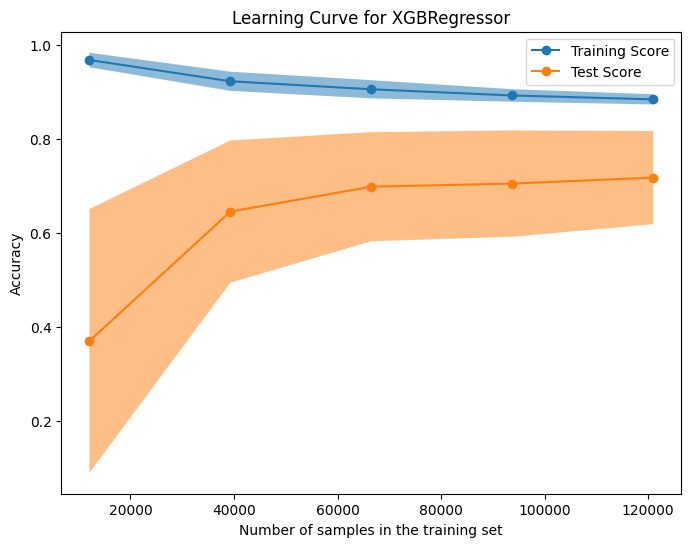

In [280]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(figsize=(8, 6))

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.1, random_state=18),
    "score_type": "both",
    "n_jobs": 5,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {model.__class__.__name__}")

plt.show()


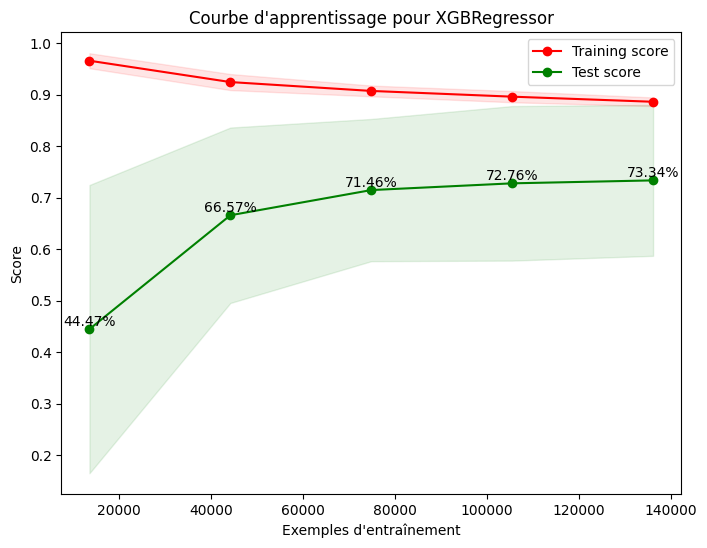

In [169]:
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
import numpy as np

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.1, random_state=18),
    "n_jobs": 4,
}

# Générer les données de la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(model, **common_params)

# Calculer la moyenne et l'écart-type pour les scores d'entraînement et de test
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

# Remplir la zone entre les écarts-types
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Ajouter les étiquettes de pourcentage aux scores de test
for i in range(len(test_scores_mean)):
    plt.text(train_sizes[i], test_scores_mean[i], f"{test_scores_mean[i]*100:.2f}%", ha='center', va='bottom')

# Ajouter un titre et des étiquettes
plt.title(f"Courbe d'apprentissage pour {model.__class__.__name__}")
plt.xlabel("Exemples d'entraînement")
plt.ylabel("Score")
plt.legend(loc="best")

# Afficher le graphique
plt.show()


In [260]:
with mlflow.start_run(run_name="XGBRegressor"):
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("RMSE", RMSE)
    mlflow.log_metric("MAE", MAE)


### XGBR GridSearch

In [270]:
from sklearn.model_selection import GridSearchCV

xgb_reg = XGBRegressor()

# Définissez la grille des hyperparamètres à explorer
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
}

# Effectuez la recherche de grille
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtenez les meilleurs hyperparamètres
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)


Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


In [73]:
X

,Code postal_x,Surface Carrez du 1er lot,Nombre pieces principales,code_region
0,1000.0,31.68,1.0,84.0
26,1000.0,78.03,3.0,84.0
52,1000.0,74.07,3.0,84.0
78,1000.0,91.47,4.0,84.0
104,1000.0,48.48,2.0,84.0
...,...,...,...,...
4702170,75003.0,86.37,4.0,4.0
4702171,75003.0,60.98,3.0,4.0
4702172,75008.0,37.07,1.0,4.0
4702173,75008.0,63.60,2.0,4.0


In [271]:
best_xgb_reg = XGBRegressor(**best_params)

In [272]:
best_xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [273]:
# Prédiction sur l'ensemble de test
predictions = best_xgb_reg.predict(X_test)

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)

# Affichage du score
print(f"Erreur quadratique moyenne (MSE) : {mse}")

Erreur quadratique moyenne (MSE) : 130091363258.31526


In [275]:
# Calcul du coefficient de détermination
r2 = r2_score(y_test, predictions)

# Affichage du score R²
print(f"Coefficient de détermination (R²) : {r2}")

Coefficient de détermination (R²) : 0.8102182254958386


In [276]:
RMSE = np.sqrt(mse)
RMSE

360681.8033368405

In [277]:
MAE = neg_mean_absolute_error(y_test, predictions)
MAE

84978.45569889813

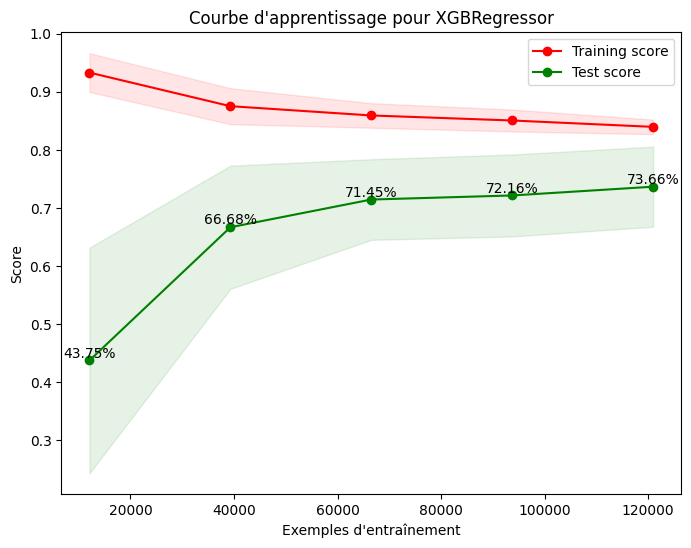

In [278]:
common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=18),
    "n_jobs": 4,
}

# Générer les données de la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(best_xgb_reg, **common_params)

# Calculer la moyenne et l'écart-type pour les scores d'entraînement et de test
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

# Remplir la zone entre les écarts-types
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Ajouter les étiquettes de pourcentage aux scores de test
for i in range(len(test_scores_mean)):
    plt.text(train_sizes[i], test_scores_mean[i], f"{test_scores_mean[i]*100:.2f}%", ha='center', va='bottom')

# Ajouter un titre et des étiquettes
plt.title(f"Courbe d'apprentissage pour {best_xgb_reg.__class__.__name__}")
plt.xlabel("Exemples d'entraînement")
plt.ylabel("Score")
plt.legend(loc="best")

# Afficher le graphique
plt.show()

In [268]:
with mlflow.start_run(run_name="XGBRegressor Gridsearch"):
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("RMSE", RMSE)
    mlflow.log_metric("MAE", MAE)
    mlflow.end_run()

## XGB RandomSearch

In [231]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.001, 0.1),
    'max_depth': randint(3, 6)
}

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=10,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    random_state=18
)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Meilleurs hyperparamètres :", best_params)


Meilleurs hyperparamètres : {'learning_rate': 0.0888601470921552, 'max_depth': 5, 'n_estimators': 166}


In [232]:
best_xgb_reg = XGBRegressor(**best_params)
best_xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0888601470921552, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=166, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [233]:
# Prédiction sur l'ensemble de test
predictions = best_xgb_reg.predict(X_test)

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)

# Affichage du score
print(f"Erreur quadratique moyenne (MSE) : {mse}")

Erreur quadratique moyenne (MSE) : 141524900056.43286


In [234]:
# Calcul du coefficient de détermination
r2 = r2_score(y_test, predictions)

# Affichage du score R²
print(f"Coefficient de détermination (R²) : {r2}")

Coefficient de détermination (R²) : 0.7935385870628338


In [235]:
RMSE = np.sqrt(mse)
RMSE

376197.9532858105

In [236]:
mean_absolute_error(y_test, predictions)

89225.70500696558

In [145]:
import joblib

joblib.dump(best_xgb_reg, 'xgb.pkl')


['xgb.pkl']